In [580]:
import numpy as np
import mne
from sklearn.neighbors import NearestNeighbors
import re
from collections import OrderedDict
import matplotlib.pyplot as plt

In [273]:
random_state = 42

In [268]:
response_event_dict = {
    'RE*ex*2_n*2_c_1*num_separator': 1036,
    'RE*ex*1_n*1_c_1*num_separator': 1042,
    'RE*ex*1_n*1_c_2*num_separator': 1045,
    'RE*ex*1_n*2_c_1*num_separator': 1048,
    'RE*ex*2_n*2_c_2*num_separator': 1052,
    'RE*ex*2_n*1_c_1*num_separator': 1055
}

new_response_event_dict = {"correct_response": 0, "error_response": 1}

events_mapping = {
    'correct_response': [1036, 1042],
    'error_response': [1045, 1048, 1052, 1055],
}

In [562]:
def read_trigger_map(file_name):
    line_count = 0
    trigger_map = []
    with open(file_name, 'r') as file:
        # Read each line and increment the counter
        line = file.readline()
        try:
            match = re.search("(.*):(.*)(\\n)", line)
            trigger = (match.group(1), match.group(2), )
            trigger_map.append(trigger)
        except:
            pass
        while line:
            line_count += 1
            line = file.readline()
            try:
                match = re.search("(.*):(.*)(\\n)", line)
                trigger = (match.group(1), match.group(2), )
                trigger_map.append(trigger)
            except:
                pass

    assert len(trigger_map) == line_count

    return trigger_map

def create_triggers_dict(trigger_map):
    triggers_codes = [item[1] for item in trigger_map]
    # Create an ordered dictionary to maintain order and remove duplicates
    unique_ordered_dict = OrderedDict.fromkeys(triggers_codes)
    numbered_dict = {key: 1000 + number for number, key in enumerate(unique_ordered_dict.keys())}
    reversed_numbered_dict = {1000 + number: key for number, key in enumerate(unique_ordered_dict.keys())}
    return numbered_dict, reversed_numbered_dict

def replace_trigger_names(raw, trigger_map):
    # Replace event IDs in the Raw object
    events = mne.find_events(raw, stim_channel='Status')
    new_events_list = events.copy()

    assert len(events) == len(trigger_map)

    trigger_map_codes, mapping = create_triggers_dict(trigger_map)

    for idx, event in enumerate(events):
        event_id = str(event[2])[-1]
        trigger_id = trigger_map[idx][0]
        trigger_new_code = trigger_map[idx][1]
        assert event_id == trigger_id

        trigger_new_code_int = trigger_map_codes[trigger_new_code]
        new_events_list[idx][2] = trigger_new_code_int

    annot_from_events = mne.annotations_from_events(
        events=new_events_list,
        event_desc=mapping,
        sfreq=raw.info["sfreq"],
        orig_time=raw.info["meas_date"],
    )
    raw_copy = raw.copy()
    raw_copy.set_annotations(annot_from_events)

    return raw_copy


def create_epochs(
        raw,
        tmin=-.1,
        tmax=.6,
        events_to_select=response_event_dict,  # response_event_dict
        new_events_dict=new_response_event_dict,  # new_response_event_dict
        events_mapping=events_mapping,  # events_mapping
        reject=None,
        reject_by_annotation=False,
):
    # select specific events
    events, event_ids = mne.events_from_annotations(raw, event_id=events_to_select)

    # Merge different events of one kind
    for mapping in events_mapping:
        events = mne.merge_events(
            events=events,
            ids=events_mapping[mapping],
            new_id=new_events_dict[mapping],
            replace_events=True,
        )

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=new_events_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=reject_by_annotation,
        preload=True,
        reject=reject,
        picks=['eeg', 'eog'],
    )
    
    return epochs


def ocular_correction_ica(raw, raw_unfiltered, veog=[], heog=[]):
    # filtered_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
    # 
    # # peak-to-peak amplitude rejection parameters to exclude very noisy epochs
    # epochs_ica = create_epochs(
    #     filtered_raw,
    #     tmin=-.4,
    #     tmax=.8,
    #     reject=dict(eeg=100e-5),
    # )
    # 
    # ica = mne.preprocessing.ICA(
    #     n_components=36,
    #     method='infomax',
    #     max_iter="auto",
    #     random_state=random_state
    # )
    # ica.fit(epochs_ica)
    # 
    # ica.exclude = []
    # # find which ICs match the VEOG pattern
    # eog_epochs = mne.preprocessing.create_eog_epochs(
    #     filtered_raw,
    #     tmin=-0.5, tmax=0.5
    # )
    # 
    # eog_epochs.plot_image(combine="mean")
    # eog_epochs.average().plot_joint()
    # 
    # veog_indices, veog_scores = ica.find_bads_eog(
    #     eog_epochs,
    #     ch_name=veog,
    #     threshold=0.9,
    #     measure='correlation'
    # )
    # heog_indices, heog_scores = ica.find_bads_eog(
    #     eog_epochs,
    #     ch_name=heog,
    #     threshold=0.8,
    #     measure='correlation'
    # )
    # 
    # print(f'Excluded ICA components: {veog_indices + heog_indices}')
    # 
    # ica.plot_components(veog_indices + heog_indices)
    # 
    # ica.exclude = veog_indices + heog_indices
    # 
    # reconstructed_epochs = epochs.copy()
    # ica.apply(reconstructed_epochs)

    filtered_raw_ica = raw_unfiltered.copy().drop_channels(['EXG7', 'EXG8']).filter(l_freq=1.0, h_freq=None)

    ica = mne.preprocessing.ICA(
        n_components=12,
        method='infomax',
        max_iter="auto",
        random_state=random_state
    )
    ica.fit(filtered_raw_ica)
    
    ica.exclude = []
    
    # find which ICs match the VEOG pattern
    veog_indices, veog_scores = ica.find_bads_eog(
        filtered_raw_ica,
        ch_name=veog,
        threshold=0.9,
        measure='correlation'
    )

    # find which ICs match the HEOG pattern
    heog_indices, heog_scores = ica.find_bads_eog(
        filtered_raw_ica,
        ch_name=heog,
        threshold=0.7,
        measure='correlation'
    )    
    
    print(f'Excluded ICA components:\nVEOG: {veog_indices}\nHEOG: {heog_indices}')
    fig = ica.plot_components(veog_indices + heog_indices)
    
    ica.exclude = veog_indices + heog_indices
    # 
    reconstructed_raw = raw.copy()
    ica.apply(reconstructed_raw)

    del filtered_raw_ica

    return reconstructed_raw


def get_k_nearest_neighbors(target_ch_name, epochs, k=6):
    """
    Finds k nearest neighbors of given channel according to the 3D channels positions from the Epoch INFO
    :param target_ch_name: String
        Name of the target channel.
    :param epochs: mne Epochs
        Epochs with info attribute that consists of channels positions.
    :param k: int
        Number of neighbors to use by default for kneighbors queries. 
    :return: 
        indices: ndarray of shape (n_neighbors)
            Indices of the nearest channels.
        neighbor_ch_names: ndarray of shape (n_neighbors)
            Names of the nearest channels.   
    """
    epochs_copy_eeg_channels = epochs.copy().pick('eeg')
    info = epochs_copy_eeg_channels.info
    ch_names = epochs_copy_eeg_channels.info['ch_names']
    
    chs = [info["chs"][pick] for pick in np.arange(0,len(ch_names))]
    electrode_positions_3d =[]
    
    for ch in chs:
        electrode_positions_3d.append((ch['ch_name'], ch["loc"][:3]))
    
    neighbors_model = NearestNeighbors(n_neighbors=k+1, algorithm='auto')
    ch_coordinates = np.array([ch_name_coordinates[1] for ch_name_coordinates in electrode_positions_3d])

    neighbors_model.fit(ch_coordinates)

    target_ch_coordinates = np.array([ch_name_coordinates[1] for ch_name_coordinates in electrode_positions_3d if ch_name_coordinates[0] == target_ch_name])
    
    target_ch_coordinates = target_ch_coordinates.reshape(1,-1)

    distances, indices = neighbors_model.kneighbors(target_ch_coordinates)
    neighbor_ch_names = []
    
    # Print the nearest neighbors without the first (self) neighbor
    # print(f"{k} Nearest Neighbors of {target_ch_name}:")
    for i, (distance, index) in enumerate(zip(distances.flatten(), indices.flatten())):
        if i == 0:
            pass
        else:
            neighbor_point = electrode_positions_3d[index]
            # print(f"Neighbor {i + 1}: Index {index}, Distance {distance:.2f}, Coordinates {neighbor_point}")
            neighbor_ch_names.append(neighbor_point[0])
            
    return indices.flatten()[1:], np.array(neighbor_ch_names)


def find_bad_trails(epochs):
    """
    Channels that meet following conditions will be marked as bad for the trail:
        (1) Channels with a voltage difference of 100 μV through the duration of the epoch;
        (2) Channels that were flat;
        (3) Channels with more than a 30 μV difference with the nearest six neighbors; 
    :param mne Epochs 
        Epochs to find bad channels per trial. 
    :return: drop_log: tuple of n_trials length
        Tuple representing bad channels names per trial.
    """
    epochs_copy = epochs.copy()
    
    # channels with a voltage difference of 100 μV through the duration of the epoch
    reject_criteria = dict(eeg=100e-6)
    # flat channels (less than 1 µV of peak-to-peak difference)
    flat_criteria = dict(eeg=1e-6)
    
    epochs_copy.drop_bad(reject=reject_criteria, flat=flat_criteria)
    drop_log = epochs_copy.drop_log

    # channels with more than a 30 μV difference with the nearest six neighbors
    for idx, _ in enumerate(epochs_copy):
        epoch = epochs[idx]
        epoch_data = epoch.get_data(copy=True)
        for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
            mean_channel_data = np.array(np.mean(epoch_data[0,ch_idx,:]))
    
            ch_neighbors_indices, ch_neighbors_names = get_k_nearest_neighbors(
                target_ch_name = ch_name,
                epochs = epoch,
                k=6
            )
    
            mean_neighbors_data = np.array([np.mean(epoch_data[0, ch_neighbor_index, :]) 
                                            for ch_neighbor_index in ch_neighbors_indices])
    
            # # if channels has more than a 30 μV difference with the nearest six neighbors
            if (abs(mean_neighbors_data - mean_channel_data) > 30e-6).all():
                print(f'BAD------ trail index {idx}, channel: {ch_name}')
                print(mean_channel_data)
                print(mean_neighbors_data)
    
                new_drop_log_item = drop_log[idx] + (ch_name, ) if ch_name not in drop_log[idx] else drop_log[idx]
                drop_log = tuple(new_drop_log_item if i == idx else item for i, item in enumerate(drop_log))

    del epochs_copy
    
    return drop_log

def calculate_percentage(tuple_of_tuples, element):
    total_tuples = len(tuple_of_tuples)
    # Avoid division by zero
    if total_tuples == 0:
        return 0 

    tuples_with_element = sum(1 for inner_tuple in tuple_of_tuples if element in inner_tuple)
    percentage = (tuples_with_element / total_tuples)
    return percentage

def find_global_bad_channels(epochs, drop_log):
    '''
    (1) Channels with an absolute correlation with the nearest six neighboring channels that fell below .4;
    (2) Channels that were marked as bad for more than 20% of epochs;
    :param epochs: 
    :param drop_log: 
    :return: 
    '''
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True)
    concatenated_epochs_data = np.concatenate(epochs_data, axis=1)
    
    global_bad_channels_drop_log = {}
    
    # (1) Channels with an absolute correlation with the nearest six neighboring channels that fell below .4
    for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
        channel_data = concatenated_epochs_data[ch_idx]
    
        ch_neighbors_indices, ch_neighbors_names = get_k_nearest_neighbors(
            target_ch_name = ch_name,
            epochs = epochs_copy,
            k=6
        )
        channel_neighbors_data = np.array([concatenated_epochs_data[ch_neighbor_index]
                                           for ch_neighbor_index in ch_neighbors_indices])
        channels_corr = np.tril(np.corrcoef(channel_neighbors_data, channel_data), k=-1)
    
        if (abs(channels_corr[-1][:-1]) < .4).all():
            print(f'BAD------ global channel: {ch_name}, low corr')
            print(channels_corr[-1][:-1])
    
            # mark channel as globally bad
            global_bad_channels_drop_log[ch_name] = ['LOW CORR NEIGH']
            # update drop_log
            drop_log = tuple(drop_log[i] + (ch_name,)
                             if ch_name not in drop_log[i] else drop_log[i] for i, item in enumerate(drop_log))
    
    # (2) Channels that were marked as bad for more than 20% of epochs   
    for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
        percentage = calculate_percentage(drop_log, ch_name)
    
        if percentage > 0.2:
            print(f'BAD------ global channel: {ch_name}, percentage: {percentage}')
    
            if ch_name in global_bad_channels_drop_log:
                global_bad_channels_drop_log[ch_name].append('BAD FOR MORE THAN 20%')
            else:
                global_bad_channels_drop_log[ch_name] = ['BAD FOR MORE THAN 20%']
    
            # update drop_log
            drop_log = tuple(drop_log[i] + (ch_name,)
                             if ch_name not in drop_log[i] else drop_log[i] for i, item in enumerate(drop_log))
            
    del epochs_copy
            
    return drop_log, global_bad_channels_drop_log

def calculate_bad_trials(drop_log, threshold=0.1):
    """
    If more than 10% of channels were marked bad for an epoch (trial), the entire epoch was rejected
    :param drop_log: 
    :return: trials_to_drop: ndarray
    '"""
    trials_to_drop_indices = []
    epochs_copy = epochs.copy()

    if len(epochs_copy) == len(drop_log):
        threshold_items = int(threshold * len(epochs_copy.info['ch_names']))
        for idx, item in enumerate(drop_log):
            if len(item) > threshold_items:
                print(f'BAD TRAIL: {idx}')
                trials_to_drop_indices.append(idx)
        
        # update drop_log
        for trial_idx in trials_to_drop_indices:
            drop_log = tuple(drop_log[i] + ('TO DROP',) if i == trial_idx else item for i, item in enumerate(drop_log))

    else:
        print(f'Epochs length is not equal drop_log length:\nepochs: {len(epochs)}\ndrop_log: {len(drop_log)}')
    
    return trials_to_drop_indices, drop_log

def reject_bad_trials(epochs, drop_log, trials_to_drop_indices=None):
    clean_epochs = epochs.copy()
    
    clean_epochs = clean_epochs.drop(
        indices = trials_to_drop_indices,
        reason = 'MORE THAN 10% CHANNELS MARKED AS BAD',
    )
    
    # update drop_log
    for trial_idx in trials_to_drop_indices:
        drop_log = tuple(('REJECTED',) if i == trial_idx else element for i, element in enumerate(drop_log))
    
    return clean_epochs, updated_drop_log

def interpolate_bad_channels(epochs, drop_log, global_bad_channels_drop_log):
    """
    Bad channels were interpolated using spherical splines
    :param epochs: 
    :param drop_log: 
    :param global_bad_channels_drop_log: 
    :return: 
    """

    epochs_copy = epochs.copy()
    epochs_copy.info['bads'] = list(global_bad_channels_drop_log.keys())
    epochs_interpolated_bad_channels = epochs_copy.interpolate_bads(method='spline')

    # update drop log to remove interpolated channels
    updated_drop_log = drop_log
    for ch_name in list(global_bad_channels_drop_log.keys()):
        updated_drop_log = tuple(tuple(element for element in drop_log_item if element != ch_name) for drop_log_item in updated_drop_log)
    
    return epochs_interpolated_bad_channels, updated_drop_log

def create_erps_waves(epochs, drop_log, type = 'error_response', tmin=0, tmax=0.1, picks=['FCz']):
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True, picks=picks, tmin=tmin, tmax=tmax)
    events = epochs_copy.events

    eeg_data = []

    if (len(epochs_data) == len(drop_log)) & (len(events) == len(drop_log)):
        for idx, item in enumerate(drop_log):
            if events[idx][-1] == new_response_event_dict[type]:
                if ('TO DROP' in item) or any(element in item for element in picks):
                    pass
                else:
                    eeg_data.append(epochs_data[idx])
            else:
                pass
        return np.array(eeg_data)
    else:
        print(f'Epochs length is not equal to drop_log length:\nepochs: {len(epochs_data)}\ndrop_log: {len(drop_log)}')
        return None

def create_erps(epochs, drop_log, type = 'error_response', tmin=0, tmax=0.1, picks=['FCz']):
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True, picks=picks, tmin=tmin, tmax=tmax)
    events = epochs_copy.events

    erps_data = []

    if (len(epochs_data) == len(drop_log)) & (len(events) == len(drop_log)):
        for idx, item in enumerate(drop_log):
            if events[idx][-1] == new_response_event_dict[type]:
                if ('TO DROP' in item) or any(element in item for element in picks):
                    erps_data.append([None])
                else:
                    erps_data.append(np.mean(epochs_data[idx], axis=-1))
            else:
                pass
        return np.array(erps_data)
    else:
        print(f'Epochs length is not equal to drop_log length:\nepochs: {len(epochs_data)}\ndrop_log: {len(drop_log)}')
        return None

# def pre_process_eeg(input_fname, trigger_map=None, parameters=None):
#     raw = mne.io.read_raw_bdf(input_fname, eog=['EX7', 'EX8'])
# 
#     # 1. re-reference: to mastoids
#     raw.set_eeg_reference(ref_channels=['M1', 'M2'])
# 
#     # 2. 4-th order Butterworth filters
#     raw_filtered = raw.copy().filter(
#         l_freq=.1,
#         h_freq=30.0,
#         n_jobs=10,
#         method='iir',
#         iir_params=None,
#     )
# 
#     # 3. Notch filter at 50 Hz
#     raw_filtered = raw_filtered.filter(
#         freqs=np.arange(50, 251, 50),
#         n_jobs=10,
#         method='iir',
#         iir_params=None,
#     )
# 
#     # 4. segmentation -400 to 800 ms around the response
#     epochs = create_epochs(raw_filtered, tmin=-.4, tmax=.8)
# 
#     # 5. ocular artifact correction with ICA
#     refined_epochs = ocular_correction_ica(epochs, raw, heog=['EX3', 'EX4'], veog=['EX1', 'EX2'])
# 
#     # 6. Trial-wise Bad Channels Identification
#     drop_log = find_bad_trails(epochs) 
#
#     # 7. Global Bad Channel Identification - <.4 corr with 6 neigh. and channels marked as bad for more than 20% trials
#     drop_log, global_bad_channels_drop_log = find_global_bad_channels(epochs, drop_log)
#
#     # 8. calculate trails to remove
#     trials_to_drop_indices, drop_log = calculate_bad_trials(drop_log, threshold=0.1)
#
#     (# 9. Reject bad trials  # not necessary step
#     clean_epochs, _ = reject_bad_trials(refined_epochs, drop_log, trials_to_drop_indices))
#    
#     # 10. Interpolate bad channels (and thus update drop log)
#     interpolated_epochs, drop_log = interpolate_bad_channels(refined_epochs, drop_log, global_bad_channels_drop_log)
# 
#     # 11. Mark trials bad based on response times: todo (-> updates drop log)
#
#     # 12. Remove participants that have less then 6 trials
#     clean_epochs, _ = reject_bad_trials(refined_epochs, drop_log, trials_to_drop_indices))
#     if len(clean_epochs) < 6:
#           print(f"Participant ID: {id}" has not enough clean trials)
#     return None
#
#     # 13. Baseline correction
#     interpolated_epochs.apply_baseline(baseline=(-0.4, -0.2),)
#
#     # 13. ERPs scoring
#     ern_single_trials = create_erps(interpolated_epochs, drop_log, tmin=0, tmax=0.1, picks=['FCz'])
#     pe_single_trials = create_erps(interpolated_epochs, drop_log, tmin=0.2, tmax=0.4, picks=['Pz'])

In [481]:
input_fname = 'data/raw/A-GNG-000.bdf'
raw = mne.io.read_raw_bdf(
    input_fname, 
    eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], 
    exclude=['EXG5', 'EXG6'], 
    preload=True
)

try:
    raw = raw.set_montage('biosemi64')
except ValueError as e:
    if '[\'EXG7\', \'EXG8\']' in e.args[0]:
        raw = raw.set_montage('biosemi64', on_missing='ignore')
        print('On missing')
    else:
        print('Lacks important channels!')


file_path = 'data/raw/triggerMap_A-GNG-000.txt'
trigger_map = read_trigger_map(file_path)
raw_new_triggers = replace_trigger_names(raw, trigger_map)

Extracting EDF parameters from /Users/anuszka/Projects/ERPinability/data/raw/A-GNG-000.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1782783  =      0.000 ...  1740.999 secs...
On missing
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1391 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288]


In [482]:
# 1. re-reference: to mastoids
raw_ref = raw_new_triggers.copy().set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
# fig = raw_ref.plot(start=60, duration=1)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [483]:
# 2. 4-th order Butterworth filters
raw_filtered = raw_ref.copy().filter(
    l_freq=.1,
    h_freq=30.0,
    n_jobs=10,
    method='iir',
    iir_params=None,
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  66 out of  66 | elapsed:    3.1s finished


In [484]:
# 3. Notch filter at 50 Hz
raw_filtered = raw_filtered.notch_filter(
    freqs=np.arange(50, 251, 50),
    n_jobs=10,
    # method='iir',
    # iir_params=None,
)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  66 out of  66 | elapsed:    2.4s finished


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 12 components
 
Fitting ICA took 77.0s.
Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0

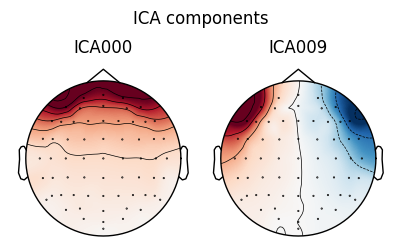

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


In [485]:
# 5. ocular artifact correction with ICA
raw_corrected_eogs = ocular_correction_ica(raw_filtered, raw_ref, heog=['EXG3', 'EXG4'], veog=['EXG1', 'EXG2'])

Used Annotations descriptions: ['RE*ex*1_n*1_c_1*num_separator', 'RE*ex*1_n*1_c_2*num_separator', 'RE*ex*1_n*2_c_1*num_separator', 'RE*ex*2_n*1_c_1*num_separator', 'RE*ex*2_n*2_c_1*num_separator', 'RE*ex*2_n*2_c_2*num_separator']
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 253 events and 1230 original time points ...
0 bad epochs dropped


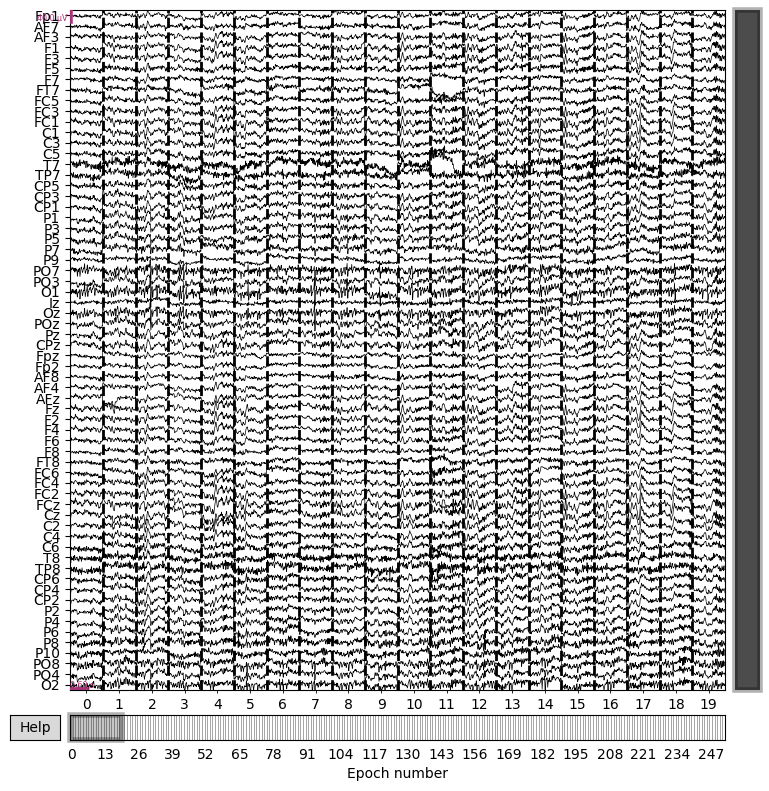

In [507]:
raw_corrected_eogs_drop_ref = raw_corrected_eogs.copy().drop_channels(['EXG7', 'EXG8']).pick('eeg')

epochs = create_epochs(
    raw_corrected_eogs_drop_ref, 
    tmin=-.4, 
    tmax=.8,
    events_to_select=response_event_dict,  # response_event_dict
    new_events_dict=new_response_event_dict,  # new_response_event_dict
    events_mapping=events_mapping,  # events_mapping
    reject=None,
    reject_by_annotation=False,
)

fig = epochs.plot(n_epochs=20, n_channels=68)

In [510]:
# 6. Trial-wise Bad Channels Identification
drop_log = find_bad_trails(epochs) 
drop_log

    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['P5']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['P7']
11 bad epochs dropped
BAD------ trail index 191, channel: P7
0.00011882221392766303
[ 2.26694963e-06 -2.27729292e-07  4.14736339e-06 -2.38718066e-06
  2.20555288e-06  3.41367366e-06]


((),
 (),
 ('O1',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('C5',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 ('P5',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('O1', 'O2'),
 (),
 (),
 (),
 (

In [511]:
# 7. Global Bad Channel Identification - <.4 corr with 6 neigh. and channels marked as bad for more than 20% trials
drop_log, global_bad_channels_drop_log = find_global_bad_channels(epochs, drop_log)

In [513]:
# 8. calculate trails to remove
trials_to_drop_indices, drop_log = calculate_bad_trials(drop_log, threshold=0.1)

In [514]:
# 10. Interpolate bad channels (and thus update drop log)
interpolated_epochs, drop_log = interpolate_bad_channels(epochs, drop_log, global_bad_channels_drop_log)

Setting channel interpolation method to {'eeg': 'spline'}.


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_59361/1685860611.py:413: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_interpolated_bad_channels = epochs_copy.interpolate_bads(method='spline')


In [516]:
# 12. Remove participants that have less then 6 trials
clean_epochs, _ = reject_bad_trials(interpolated_epochs.copy(), drop_log, trials_to_drop_indices)
if len(clean_epochs) < 6:
      print(f"Participant ID: {id} has not enough clean trials")

Dropped 0 epochs: 


In [517]:
# 13. Baseline correction
interpolated_epochs.apply_baseline(baseline=(-0.4, -0.2),)

Applying baseline correction (mode: mean)


Number of events,253
Events,correct_response: 224error_response: 29
Time range,-0.400 – 0.800 s
Baseline,-0.400 – -0.200 s


In [532]:
drop_log

((),
 (),
 ('O1',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('C5',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('FCz',),
 (),
 (),
 ('P5',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('T7',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('O1', 'O2'),
 (),
 (),
 (),
 (

In [563]:
# 13. ERPs scoring
ern_single_trials = create_erps(interpolated_epochs, drop_log, type='error_response', tmin=0, tmax=0.1, picks=['FCz'])
pe_single_trials = create_erps(interpolated_epochs, drop_log, type='error_response', tmin=0.2, tmax=0.4, picks=['Pz'])

In [566]:
error_wave = create_erps_waves(interpolated_epochs, drop_log, type='error_response', tmin=-0.1, tmax=0.6, picks=['FCz'])

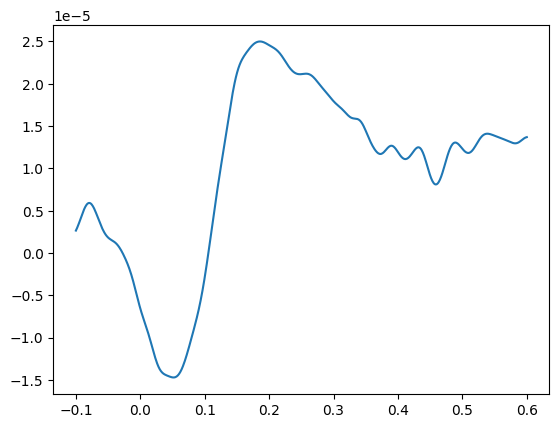

In [579]:
plt.plot(np.linspace(-0.1, 0.6, len(np.mean(error_wave, axis=0).flatten())), np.mean(error_wave, axis=0).flatten(), )

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 12 components
 
Fitting ICA took 80.8s.
Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0

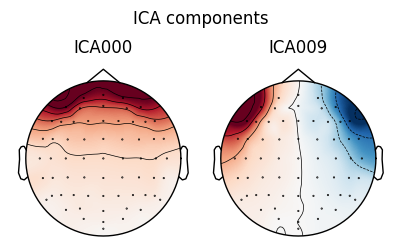

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


Measurement date,"July 01, 2022 17:10:10 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"66 EEG, 4 EOG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2, EXG3, EXG4"
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [478]:
# filtered_raw_ica = raw_ref.copy().drop_channels(['EXG7', 'EXG8']).filter(l_freq=1.0, h_freq=None)
# 
# ica = mne.preprocessing.ICA(
#     n_components=12,
#     method='infomax',
#     max_iter="auto",
#     random_state=random_state
# )
# ica.fit(filtered_raw_ica)
# 
# ica.exclude = []
# heog=['EXG3', 'EXG4']
# veog=['EXG1', 'EXG2']
# 
# # find which ICs match the VEOG pattern
# veog_indices, veog_scores = ica.find_bads_eog(
#     filtered_raw_ica,
#     ch_name=veog,
#     threshold=0.9,
#     measure='correlation'
# )
# # 
# print(f'{veog_indices}')
# 
# heog_indices, heog_scores = ica.find_bads_eog(
#     filtered_raw_ica,
#     ch_name=heog,
#     threshold=0.7,
#     measure='correlation'
# )
# print(f'{heog_indices}')
# 
# 
# print(f'Excluded ICA components: {veog_indices + heog_indices}')
# fig = ica.plot_components(veog_indices + heog_indices)
# 
# ica.exclude = veog_indices + heog_indices
# # 
# reconstructed_raw = raw_filtered.copy()
# ica.apply(reconstructed_raw)

Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

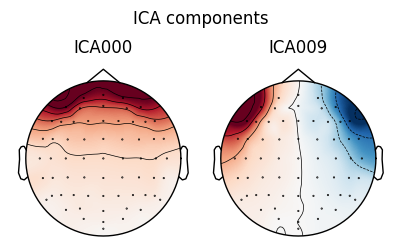

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


Measurement date,"July 01, 2022 17:10:10 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"66 EEG, 4 EOG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG1, EXG2, EXG3, EXG4"
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [474]:
# ica.exclude = []
# heog=['EXG3', 'EXG4']
# veog=['EXG1', 'EXG2']
# 
# # find which ICs match the VEOG pattern
# veog_indices, veog_scores = ica.find_bads_eog(
#     raw_ref,
#     ch_name=veog,
#     threshold=0.9,
#     measure='correlation'
# )
# # 
# print(f'{veog_indices}')
# 
# heog_indices, heog_scores = ica.find_bads_eog(
#     raw_ref,
#     ch_name=heog,
#     threshold=0.7,
#     measure='correlation'
# )
# print(f'{heog_indices}')
# 
#  
# print(f'Excluded ICA components: {veog_indices + heog_indices}')
# fig = ica.plot_components(veog_indices + heog_indices)
# 
# ica.exclude = veog_indices + heog_indices
# # 
# reconstructed_raw = raw_filtered.copy()
# ica.apply(reconstructed_raw)

In [480]:
print(heog_scores)
print(veog_scores)

[array([ 0.11012561, -0.23537677,  0.36881624,  0.23736111,  0.31734441,
        0.15941063,  0.05545093, -0.05824972, -0.02528372,  0.65513164,
        0.36196168, -0.36872098]), array([ 0.17945573, -0.22454779,  0.43969121,  0.00809103,  0.04450952,
        0.11775628,  0.01562104, -0.16748899, -0.05324979, -0.78086671,
        0.22029672, -0.3480511 ])]
[array([ 0.96912503, -0.03647819,  0.12560012,  0.07330614,  0.10491211,
        0.05215377,  0.13791582, -0.00315102,  0.0509286 ,  0.10130928,
        0.0875624 , -0.08777806]), array([-0.63464194, -0.20742545,  0.31393642,  0.1439098 ,  0.1855053 ,
        0.13690358, -0.00601493, -0.0840651 , -0.0375748 ,  0.17639501,
        0.26246881, -0.30012515])]
